In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [2]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})
df.head()


,date,sales
0,2025-08-01,31.986857
1,2025-08-02,37.539230
2,2025-08-03,42.887978
3,2025-08-04,41.252875
4,2025-08-05,25.820440


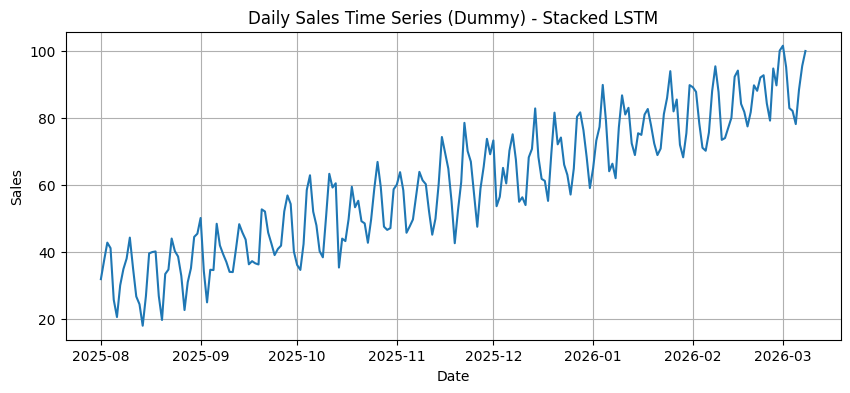

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["sales"])
plt.title("Daily Sales Time Series (Dummy) - Stacked LSTM")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [4]:
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]

print("Train:", len(train), "Test:", len(test))


Train: 176 Test: 44


In [5]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
test_scaled  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)


In [6]:
LOOKBACK = 30

def make_sequences(arr_2d, lookback):
    X, y = [], []
    for i in range(lookback, len(arr_2d)):
        X.append(arr_2d[i-lookback:i, 0])
        y.append(arr_2d[i, 0])
    X = np.array(X, dtype=np.float32)[:, :, None]  # (N, T, 1)
    y = np.array(y, dtype=np.float32)[:, None]     # (N, 1)
    return X, y

X_train, y_train = make_sequences(train_scaled, LOOKBACK)
print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: (146, 30, 1) y_train: (146, 1)


In [7]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dl = DataLoader(SeqDataset(X_train, y_train), batch_size=32, shuffle=True, drop_last=False)


In [8]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout  # dropout funciona cuando num_layers > 1
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # out: (B, T, H)
        yhat = self.fc(out[:, -1, :]) # last timestep
        return yhat

model = StackedLSTM(hidden_size=64, num_layers=2, dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


StackedLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
EPOCHS = 25
model.train()

for epoch in range(1, EPOCHS + 1):
    losses = []
    for xb, yb in dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()

        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | loss {np.mean(losses):.6f}")


epoch 01 | loss 0.394469
epoch 05 | loss 0.039109
epoch 10 | loss 0.031879
epoch 15 | loss 0.026796
epoch 20 | loss 0.015067
epoch 25 | loss 0.016431


In [10]:
model.eval()

window = train_scaled[-LOOKBACK:].copy()  # (T,1)
preds_scaled = []

for _ in range(len(test)):
    X = torch.from_numpy(window.reshape(1, LOOKBACK, 1)).float().to(device)
    with torch.no_grad():
        yhat = model(X).cpu().numpy()[0,0]
    preds_scaled.append(yhat)
    window = np.vstack([window[1:], [[yhat]]])

preds_scaled = np.array(preds_scaled, dtype=np.float32)
pred = scaler.inverse_transform(preds_scaled.reshape(-1,1)).reshape(-1)


In [11]:
model.eval()

window = train_scaled[-LOOKBACK:].copy()  # (T,1)
preds_scaled = []

for _ in range(len(test)):
    X = torch.from_numpy(window.reshape(1, LOOKBACK, 1)).float().to(device)
    with torch.no_grad():
        yhat = model(X).cpu().numpy()[0,0]
    preds_scaled.append(yhat)
    window = np.vstack([window[1:], [[yhat]]])

preds_scaled = np.array(preds_scaled, dtype=np.float32)
pred = scaler.inverse_transform(preds_scaled.reshape(-1,1)).reshape(-1)


In [12]:
mae  = mean_absolute_error(test.values, pred)
rmse = np.sqrt(mean_squared_error(test.values, pred))
mape = np.mean(np.abs((test.values - pred) / np.maximum(test.values, 1e-8))) * 100

print("Stacked LSTM Metrics")
print(f"Lookback: {LOOKBACK}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


Stacked LSTM Metrics
Lookback: 30
MAE  : 8.93
RMSE : 10.76
MAPE : 11.07%


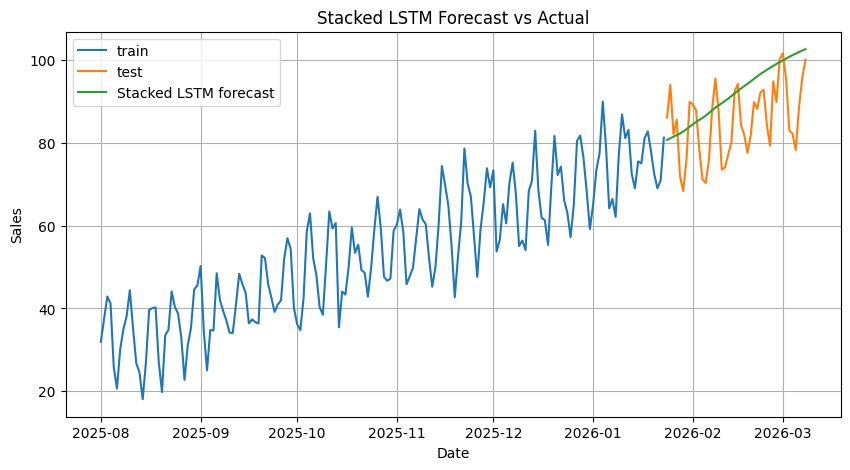

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, pred, label="Stacked LSTM forecast")
plt.title("Stacked LSTM Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
results_stacked = pd.DataFrame({
    "date": test.index,
    "y_true": test.values,
    "y_pred": pred
})
results_stacked.head()


,date,y_true,y_pred
0,2026-01-24,86.089500,80.724236
1,2026-01-25,94.056566,81.093246
2,2026-01-26,82.047333,81.486366
3,2026-01-27,85.582935,81.845367
4,2026-01-28,72.068459,82.255043
